In [1]:
import os
import sys
import importlib

os.environ["JAX_ENABLE_X64"] = "true"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['ENABLE_PJRT_COMPATIBILITY'] = 'false'
os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font_axis_label = 16

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'font.size': 12
})

In [3]:
import src
importlib.import_module(f'src')
for module in dir(src):
    if '__' not in module:
        print(module)
        importlib.import_module(f'src.{module}')
        importlib.reload(sys.modules[f'src.{module}'])
        
from src.experiments import GaussianManifold, run_experiment
from src.theory_utils_spectral import SVR_th_spectral

corr_0.667_noise_1.0_P_800_N_25_grid_4_centroid_seed_42.npz
[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


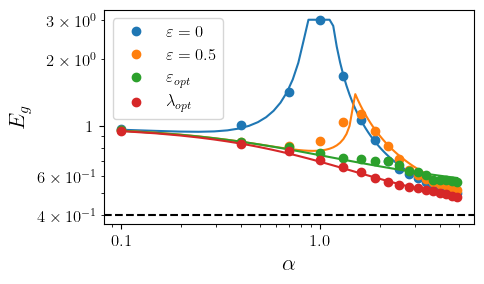

In [4]:
P, N, grid_size, num_trials = 800, 25, 4, 25

corr_list = [0.667]
noise_list = [1.0]
centroid_seed = 42
fn_list = []
fn_list = ['linsvr2']
overwrite = False

for corr in corr_list:
    for noise in noise_list:

        filename = f'corr_{corr}_noise_{noise}_P_{P}_N_{N}_grid_{grid_size}_centroid_seed_{centroid_seed}.npz'
        print(filename)

        import os.path
        if os.path.exists('./ceph/temp/'+filename) and not overwrite:
            returns = np.load('./ceph/temp/'+filename, allow_pickle=True)['returns'].tolist()


        else:
            manifold = GaussianManifold(P, N, corr=corr, noise=noise, centroid_seed=centroid_seed)

            returns = run_experiment(manifold, grid_size=grid_size, num_trials=num_trials,
                                     SVR_th=SVR_th_spectral,
                                     fn_list=fn_list,
                                     epsilon_list=np.array([-1, -2, 0.5, 0]),
                                     alpha_list=np.arange(0.1, 5, 0.3),
                                     debug=False)

            np.savez('./ceph/temp/'+filename, returns=returns)
            
            
        alpha_list = returns['alpha_list']
        alpha_list_th = returns['alpha_list_th']
        epsilon_list = returns['epsilon_list']
        grid_size = returns['grid_size']
        num_trials = returns['num_trials']
        lamb = returns['lamb']
        num_trials = returns['num_trials']
        fn_list = returns['fn_list']

        all_results_exp = returns['all_results_exp']
        all_results_th = returns['all_results_th']

        C = all_results_th['C']
        gen_err = all_results_exp[f'gen_err_{fn_list[0]}'] if len(fn_list) != 0 else C
        alpha_list = alpha_list if len(fn_list) != 0 else alpha_list_th
        C = np.clip(C, a_min=None, a_max=3)
        gen_err = np.clip(gen_err, a_min=None, a_max=3)

        plt.figure(figsize=(5, 3))
        ax = plt.gca()

        eps_plot_idx = [3, 2, 0, 1]
        eps_plot_list = [0, 0.5, -1, -2]
        for i, (eps_idx, eps) in enumerate(zip(eps_plot_idx, eps_plot_list)):
            if eps == -1:
                label = r'$\varepsilon_{opt}$'
            elif eps == -2:
                label = r'$\lambda_{opt}$'
            else:
                label = fr'$\varepsilon = {eps}$'
            plt.plot(alpha_list, gen_err[eps_idx], 'o', color=f'C{i}', label=label)
            plt.plot(alpha_list_th, C[eps_idx], color=f'C{i}')
        plt.yscale('log')
        plt.xscale('log')

        plt.axhline(all_results_th['E_inf'][0, 0], color='k', linestyle='--')
        plt.xlabel(r'$\alpha$', fontsize=font_axis_label)
        plt.ylabel(r'$E_g$', fontsize=font_axis_label)
        plt.legend()

        plt.tight_layout()
        xticks = plt.gca().get_xticks()
        ax.xaxis.set_major_formatter('{x:.1f}')
        ax.yaxis.set_major_formatter('{x:.0f}')
        print(xticks)

        if filename == 'corr_0.667_noise_1.0_P_800_N_25_grid_4_centroid_seed_42.npz':
            plt.tight_layout()
            plt.savefig('./figures/optimal_learning_curves.pdf')

        plt.show()